# Introduction to JPEG Compression: Practical tools

**Author:** Martin Beneš

## Notebook setup

As before, install `jpeglib` and download sample image `00001.tif` from ALASKA.

In [1]:
!pip install jpeglib  # install dependencies

In [2]:
# download 00001.tif from ALASKA website
import requests
res = requests.get('http://alaska.utt.fr/DATASETS/ALASKA_v2_TIFF_512_COLOR/00001.tif', verify=False)
with open('00001.tif', 'wb') as f:
    f.write(res.content)

/opt/miniconda3/envs/dev/lib/python3.8/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'alaska.utt.fr'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


## JPEG steganography embeds in the DCT domain.

We start with JPEG-compressed file `cover_qf100.jpeg`.

In [3]:
import jpeglib
import numpy as np
from PIL import Image
RGB = np.array(Image.open('00001.tif'))  # load RGB
jpeglib.from_spatial(RGB).write_spatial('cover_qf100.jpeg', qt=100)  # compress with JPEG
jpeg_q100 = jpeglib.read_dct('cover_qf100.jpeg')  # load DCT coefficients

## Simulating LSB replacement in the DCT coefficients

Next, we perform steganography using the simplest method, LSB replacement.

Instead of embedding an actual message, we simulate the changes at a given message length. The message length is calculated relative to the cover size.

In [4]:
Yc = jpeg_q100.Y  # cover
Ys = Yc.copy()  # stego
qt = jpeg_q100.qt[:1]  # QT

We choose a relative message size.

In [5]:
alpha = .4  # relative message length, 0.4 bits per non-zero AC

With a probability of $\frac{1}{2}$, the AC coefficient to be embedded already has the desired LSB. Hence, the probability that the AC coefficient needs to be changed is $1 - \frac{1}{2} = \frac{1}{2}$.

In [6]:
change_probability = np.ones(Yc.shape) / 2 * alpha

We embed into the non-zero AC DCT coefficients only.

In [7]:
change_probability[Yc == 0] = 0  # do not change zeros
change_probability[:, :, 0, 0] = 0  # do not change DC

The changed positions are chosen randomly.

In [8]:
rng = np.random.default_rng(12345)
to_be_changed_mask = rng.random(Yc.shape) < change_probability

At the selected positions, we perform LSB replacement.

In [9]:
Ys[to_be_changed_mask & ((Yc % 2) != 0)] -= 1 # Embedding into odd coefficients -> substract 1
Ys[to_be_changed_mask & ((Yc % 2) == 0)] += 1 # Embedding into even coefficients -> add 1

We are done. We can check the cover and stego images side by side.

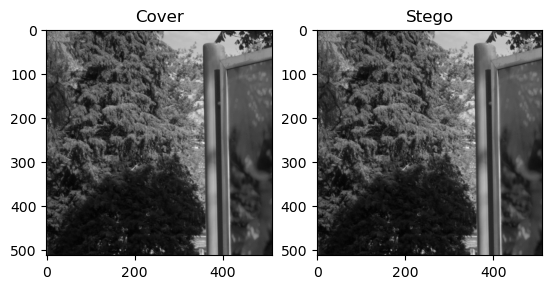

In [10]:
# write cover and stego back
jpeglib.from_dct(Y=Yc, qt=qt).write_dct('cover_gray.jpeg')
jpeglib.from_dct(Y=Ys, qt=qt).write_dct('lsbr_0.4_gray.jpeg')

# load spatial
rgb_cover = jpeglib.read_spatial('cover_gray.jpeg').spatial
rgb_stego = jpeglib.read_spatial('lsbr_0.4_gray.jpeg').spatial

import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2)
axes[0].imshow(rgb_cover[:, :, 0], cmap='gray')
axes[0].set_title('Cover')
axes[1].imshow(rgb_stego[:, :, 0], cmap='gray')
axes[1].set_title('Stego');

Although the images appear identical, many pixels have now different values.

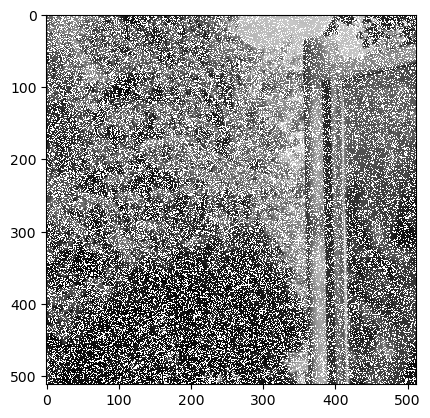

In [11]:
rgb_cover[rgb_cover != rgb_stego] = 255
plt.imshow(rgb_cover, cmap='gray', interpolation='nearest');

## LSB replacement creates an asymmetric histogram

LSB replacement evens out neighboring pairs and the histogram is visibly asymmetric.

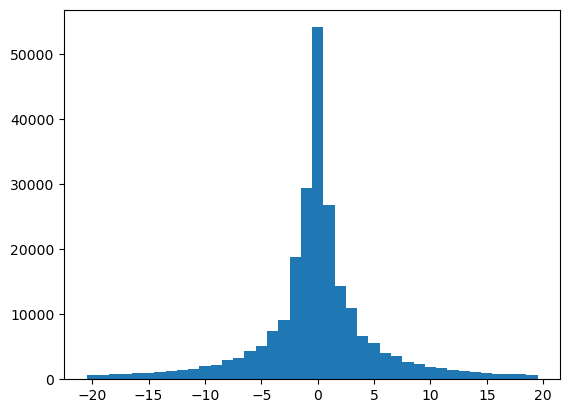

In [12]:
jpeg = jpeglib.read_dct('lsbr_0.4_gray.jpeg')
N = 40
plt.hist(jpeg.Y.flatten(), bins=N, range=(-N//2-.5, N//2-.5));

## LSB sampling preserves the histogram

LSB sampling is a slight modification of the steganographic algorithm, which removes this defect.

Instead of always incrementing even numbers and always decrementing odd numbers, LSB sampling chooses incrementing and decrementing randomly.

In [13]:
Ys = Yc.copy()  # stego
Ys[to_be_changed_mask] += rng.choice([-1, 1], to_be_changed_mask.sum(), replace=True)  # sampling
jpeglib.from_dct(Y=Ys, qt=qt).write_dct('lsbm_0.4_gray.jpeg')

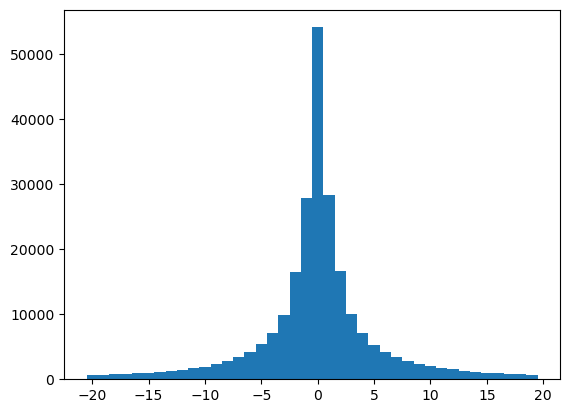

In [14]:
jpeg = jpeglib.read_dct('lsbm_0.4_gray.jpeg')
N = 40
plt.hist(jpeg.Y.flatten(), bins=N, range=(-N//2-.5, N//2-.5));

## Steganography disrupts the rounding error in the decompressed domain

However, the steganalyst can look at a different statistic, e.g., the rounding error in the decompressed domain. The rounding error in the decompressed domains can be used for a *Reverse JPEG Compatibility Attack* (RJCA).

For this RJCA, we have to implement JPEG decompression in Python, without the final rounding.

In [15]:
Yc_deq = Yc * jpeg.qt[0].reshape(1, 1, 8, 8)  # dequantize the quantized AC coefficients

In [16]:
from scipy.fftpack import idct
idct2D = lambda y: idct(idct(y, axis=1, norm='ortho'), axis=0, norm='ortho')  # inverse DCT

In [17]:
# For each block, convert the 8x8 dequantized DCT coefficients to the spatial domain
Xc = np.empty(Ys.shape)
for h in range(Yc.shape[0]):
    for w in range(Yc.shape[1]):
        Xc[h, w] = idct2D(Yc_deq[h, w])

Having decompressed the image, we can now look at it.

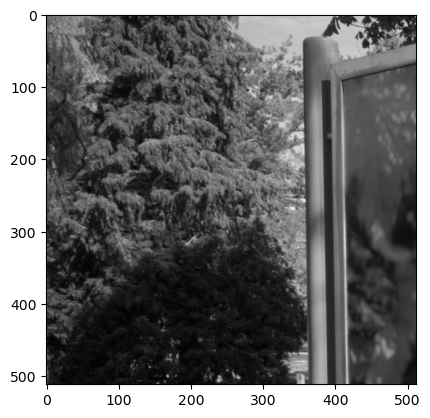

In [18]:
decompressed = Xc.transpose(0, 2, 1, 3).reshape(Yc.shape[0]*8, -1)  # deblockify
plt.imshow(decompressed, cmap='gray');

Next, we compute the rounding error in the decompressed domain. Its distribution is bounded to $[-0.5,0.5]$, and has a bell shape.

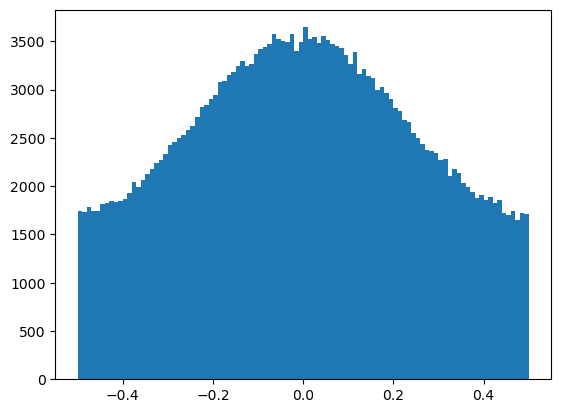

In [19]:
error_c = Xc - np.round(Xc)
plt.hist(error_c.flatten(), bins=100);

We compute the rounding error of the stego image, too. The bell shape is gone. Instead, the rounding error resembles a uniform distribution.

In [20]:
Ys_deq = Ys * jpeg.qt[0].reshape(1, 1, 8, 8)  # dequantize
Xs = np.empty(Ys.shape)
for h in range(Ys.shape[0]):
    for w in range(Ys.shape[1]):
        Xs[h, w] = idct2D(Ys_deq[h, w])

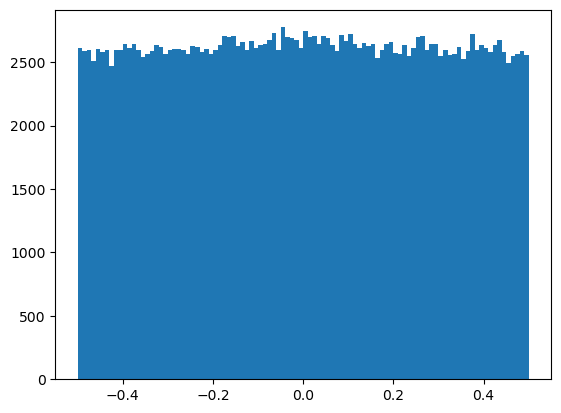

In [21]:
error_s = Xs - np.round(Xs)
plt.hist(error_s.flatten(), bins=100);

To distinguish cover and stego images with a single number, we can compare the rounding error variances. Steganography increases the variance towards 1/12.

In [22]:
np.var(error_c)

0.06567882881909116

In [23]:
np.var(error_s)

0.08248026824475388

In [24]:
1/12  # variance of uniform distribution

0.08333333333333333

## Hands-on: Detect JPEG steganography

- You are given 10 JPEG images in directory `unknown`.
- Use what you learnt to detect steganography.

In [25]:
# download the 10 images in a zip
res = requests.get('https://github.com/uibk-uncover/prague-jpeg-demo/raw/main/img/unknown.zip')
with open('unknown.zip', 'wb') as f:
    f.write(res.content)
# extract the zip
import zipfile
with zipfile.ZipFile('unknown.zip', 'r') as zObject:
    zObject.extractall(path='.')